# Import Libraries

In [1]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers.recurrent import LSTM
from keras.utils import plot_model

# Pre-processing Function

In [2]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

# Training Model Function

In [3]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {
                  'LSTM' : LSTM,
                 }


    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(inputs, [out1, out2, out3])
    

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

# Plotting Functions

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def load_data(filename):
    
    df = pd.read_csv(filename)
    
# Time  
    t = df.loc[:, ['TIME']] 
    t *= 24 # Converting time from DAY to HOUR
# Rate
    qo = df.loc[:, ['WOPR-Well01', 'WOPR-Well02', 'WOPR-Well03']]
    qw = df.loc[:, ['WWPR-Well01', 'WWPR-Well02', 'WWPR-Well03']]
    wc = df.loc[:, ['WWCT-Well01', 'WWCT-Well02', 'WWCT-Well03']]
#Pressure
    p = df.loc[:, ['WBHP-Well01', 'WBHP-Well02', 'WBHP-Well03']]
    
    return t, qo, qw, wc, p

def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):

    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):

    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
   
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['TIME'], x['WWPR-Well01'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['TIME'], x['WOPR-Well01'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0, max(max(x['WWPR-Well01'].values), max(x['WOPR-Well01'].values)) + 10)

    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR-Well02'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR-Well02'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR-Well02'].values), max(x['WOPR-Well02'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR-Well03'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR-Well03'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR-Well03'].values), max(x['WOPR-Well03'].values)) + 10)

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


# Load Data

In [5]:
t, qo, qw, wc, p = load_data('https://raw.githubusercontent.com/KarimMAJDOUB/Reservoir-History-matching-using-Recurrent-Neural-Network-LSTM-/master/data/Wells_dataset.csv')


# Flow Rate Prediction

### Pre-processing

In [6]:
# Group the input
X_raw = pd.concat([p['WBHP-Well01'], p['WBHP-Well02'], p['WBHP-Well03']], axis=1, join='inner')
Y_raw = pd.concat([qo['WOPR-Well01'], qo['WOPR-Well02'], qo['WOPR-Well02']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)


# of data:  1235
# of data:  245
# of data:  246


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


### Training & Validation of the Model 

In [7]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='LSTM')

Epoch 1/300
5/5 [==============================] - 14s 3s/step - loss: 0.3256 - dense_1_loss: 0.0872 - dense_2_loss: 0.1251 - dense_3_loss: 0.1132 - dense_1_mae: 0.2511 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.3052 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.2878 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.1461 - val_dense_1_loss: 0.0900 - val_dense_2_loss: 0.0271 - val_dense_3_loss: 0.0290 - val_dense_1_mae: 0.2546 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.1367 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.1376 - val_dense_3_accuracy: 0.0000e+00
Epoch 2/300
5/5 [==============================] - 12s 2s/step - loss: 0.1568 - dense_1_loss: 0.0533 - dense_2_loss: 0.0553 - dense_3_loss: 0.0482 - dense_1_mae: 0.1869 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.1856 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.1751 - dense_3_accuracy: 0.0000e+00 - val_loss: 0.0531 - val_dense_1_loss: 0.0177 - val_dense_2_loss: 0.0184 - val_dense_3_loss: 0.0170 - val

Epoch 15/300
5/5 [==============================] - 15s 3s/step - loss: 0.0532 - dense_1_loss: 0.0165 - dense_2_loss: 0.0188 - dense_3_loss: 0.0179 - dense_1_mae: 0.0921 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0961 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0937 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0214 - val_dense_1_loss: 0.0060 - val_dense_2_loss: 0.0075 - val_dense_3_loss: 0.0079 - val_dense_1_mae: 0.0723 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0818 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0830 - val_dense_3_accuracy: 0.0000e+00
Epoch 16/300
5/5 [==============================] - 15s 3s/step - loss: 0.0517 - dense_1_loss: 0.0156 - dense_2_loss: 0.0188 - dense_3_loss: 0.0174 - dense_1_mae: 0.0858 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0970 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.0951 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0192 - val_dense_1_loss: 0.0038 - val_dense_2_loss: 0.0075 - val_dense_3_loss: 0.0079 - v

Epoch 29/300
5/5 [==============================] - 15s 3s/step - loss: 0.0341 - dense_1_loss: 0.0111 - dense_2_loss: 0.0115 - dense_3_loss: 0.0115 - dense_1_mae: 0.0672 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0742 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.0746 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0146 - val_dense_1_loss: 0.0057 - val_dense_2_loss: 0.0044 - val_dense_3_loss: 0.0044 - val_dense_1_mae: 0.0553 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0645 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0629 - val_dense_3_accuracy: 0.0000e+00
Epoch 30/300
5/5 [==============================] - 16s 3s/step - loss: 0.0303 - dense_1_loss: 0.0106 - dense_2_loss: 0.0098 - dense_3_loss: 0.0099 - dense_1_mae: 0.0671 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0629 - dense_2_accuracy: 0.0000e+00 - dense_3_mae: 0.0634 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0103 - val_dense_1_loss: 0.0028 - val_dense_2_loss: 0.0039 - val_dense_3_loss: 0.0036 - v

Epoch 43/300
5/5 [==============================] - 13s 3s/step - loss: 0.0278 - dense_1_loss: 0.0126 - dense_2_loss: 0.0077 - dense_3_loss: 0.0076 - dense_1_mae: 0.0818 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0581 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0572 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0108 - val_dense_1_loss: 0.0048 - val_dense_2_loss: 0.0030 - val_dense_3_loss: 0.0030 - val_dense_1_mae: 0.0614 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0527 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0517 - val_dense_3_accuracy: 0.0000e+00
Epoch 44/300
5/5 [==============================] - 14s 3s/step - loss: 0.0296 - dense_1_loss: 0.0118 - dense_2_loss: 0.0089 - dense_3_loss: 0.0088 - dense_1_mae: 0.0724 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0566 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0569 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0091 - val_dense_1_loss: 0.0027 - val_dense_2_loss: 0.0033 - val_dense_3_loss: 0.0031 - v

Epoch 57/300
5/5 [==============================] - 15s 3s/step - loss: 0.0242 - dense_1_loss: 0.0083 - dense_2_loss: 0.0078 - dense_3_loss: 0.0081 - dense_1_mae: 0.0574 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0583 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0593 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0114 - val_dense_1_loss: 0.0028 - val_dense_2_loss: 0.0042 - val_dense_3_loss: 0.0044 - val_dense_1_mae: 0.0381 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0468 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0479 - val_dense_3_accuracy: 0.0000e+00
Epoch 58/300
5/5 [==============================] - 16s 3s/step - loss: 0.0264 - dense_1_loss: 0.0089 - dense_2_loss: 0.0085 - dense_3_loss: 0.0090 - dense_1_mae: 0.0602 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0659 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0688 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0076 - val_dense_1_loss: 0.0028 - val_dense_2_loss: 0.0024 - val_dense_3_loss: 0.0023 - v

Epoch 71/300
5/5 [==============================] - 12s 2s/step - loss: 0.0171 - dense_1_loss: 0.0067 - dense_2_loss: 0.0052 - dense_3_loss: 0.0051 - dense_1_mae: 0.0464 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0485 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0465 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0030 - val_dense_1_loss: 0.0013 - val_dense_2_loss: 7.8657e-04 - val_dense_3_loss: 8.3298e-04 - val_dense_1_mae: 0.0237 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0228 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0233 - val_dense_3_accuracy: 0.0000e+00
Epoch 72/300
5/5 [==============================] - 14s 3s/step - loss: 0.0157 - dense_1_loss: 0.0066 - dense_2_loss: 0.0046 - dense_3_loss: 0.0045 - dense_1_mae: 0.0459 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0426 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0423 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0065 - val_dense_1_loss: 0.0021 - val_dense_2_loss: 0.0021 - val_dense_3_loss: 0.

Epoch 85/300
5/5 [==============================] - 15s 3s/step - loss: 0.0143 - dense_1_loss: 0.0062 - dense_2_loss: 0.0041 - dense_3_loss: 0.0040 - dense_1_mae: 0.0445 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0370 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0373 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0035 - val_dense_1_loss: 0.0010 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 0.0012 - val_dense_1_mae: 0.0159 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0289 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0296 - val_dense_3_accuracy: 0.0000e+00
Epoch 86/300
5/5 [==============================] - 13s 3s/step - loss: 0.0140 - dense_1_loss: 0.0061 - dense_2_loss: 0.0039 - dense_3_loss: 0.0040 - dense_1_mae: 0.0445 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0390 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0391 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0038 - val_dense_1_loss: 0.0014 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 0.0013 - v

Epoch 99/300
5/5 [==============================] - 11s 2s/step - loss: 0.0129 - dense_1_loss: 0.0057 - dense_2_loss: 0.0037 - dense_3_loss: 0.0036 - dense_1_mae: 0.0465 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0376 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0382 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0027 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 7.6560e-04 - val_dense_3_loss: 7.2156e-04 - val_dense_1_mae: 0.0240 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0245 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0237 - val_dense_3_accuracy: 0.0000e+00
Epoch 100/300
5/5 [==============================] - 11s 2s/step - loss: 0.0126 - dense_1_loss: 0.0057 - dense_2_loss: 0.0036 - dense_3_loss: 0.0033 - dense_1_mae: 0.0440 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0346 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0337 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0042 - val_dense_1_loss: 0.0018 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 0

Epoch 113/300
5/5 [==============================] - 14s 3s/step - loss: 0.0123 - dense_1_loss: 0.0056 - dense_2_loss: 0.0033 - dense_3_loss: 0.0034 - dense_1_mae: 0.0443 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0336 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0352 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_1_loss: 8.8226e-04 - val_dense_2_loss: 7.3838e-04 - val_dense_3_loss: 7.4120e-04 - val_dense_1_mae: 0.0213 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0237 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0239 - val_dense_3_accuracy: 0.0000e+00
Epoch 114/300
5/5 [==============================] - 14s 3s/step - loss: 0.0128 - dense_1_loss: 0.0062 - dense_2_loss: 0.0034 - dense_3_loss: 0.0033 - dense_1_mae: 0.0536 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0349 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0343 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0038 - val_dense_1_loss: 0.0015 - val_dense_2_loss: 0.0012 - val_dense_3_lo

Epoch 127/300
5/5 [==============================] - 11s 2s/step - loss: 0.0121 - dense_1_loss: 0.0051 - dense_2_loss: 0.0036 - dense_3_loss: 0.0034 - dense_1_mae: 0.0433 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0384 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0385 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_1_loss: 0.0014 - val_dense_2_loss: 6.9601e-04 - val_dense_3_loss: 7.5419e-04 - val_dense_1_mae: 0.0298 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0215 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0223 - val_dense_3_accuracy: 0.0000e+00
Epoch 128/300
5/5 [==============================] - 11s 2s/step - loss: 0.0113 - dense_1_loss: 0.0047 - dense_2_loss: 0.0033 - dense_3_loss: 0.0033 - dense_1_mae: 0.0398 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0356 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0358 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0041 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 

Epoch 141/300
5/5 [==============================] - 12s 2s/step - loss: 0.0108 - dense_1_loss: 0.0046 - dense_2_loss: 0.0031 - dense_3_loss: 0.0031 - dense_1_mae: 0.0389 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0363 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0361 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_1_loss: 6.3099e-04 - val_dense_2_loss: 8.8821e-04 - val_dense_3_loss: 9.1494e-04 - val_dense_1_mae: 0.0131 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0274 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0279 - val_dense_3_accuracy: 0.0000e+00
Epoch 142/300
5/5 [==============================] - 13s 3s/step - loss: 0.0109 - dense_1_loss: 0.0047 - dense_2_loss: 0.0031 - dense_3_loss: 0.0031 - dense_1_mae: 0.0391 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0358 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0365 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0035 - val_dense_1_loss: 0.0023 - val_dense_2_loss: 6.2116e-04 - val_dense_

Epoch 155/300
5/5 [==============================] - 12s 2s/step - loss: 0.0125 - dense_1_loss: 0.0047 - dense_2_loss: 0.0039 - dense_3_loss: 0.0039 - dense_1_mae: 0.0458 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0439 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0437 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0017 - val_dense_1_loss: 8.9160e-04 - val_dense_2_loss: 3.7940e-04 - val_dense_3_loss: 3.8099e-04 - val_dense_1_mae: 0.0208 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0160 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0161 - val_dense_3_accuracy: 0.0000e+00
Epoch 156/300
5/5 [==============================] - 13s 3s/step - loss: 0.0110 - dense_1_loss: 0.0041 - dense_2_loss: 0.0036 - dense_3_loss: 0.0033 - dense_1_mae: 0.0354 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0416 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0401 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0101 - val_dense_1_loss: 0.0030 - val_dense_2_loss: 0.0035 - val_dense_3_lo

Epoch 169/300
5/5 [==============================] - 11s 2s/step - loss: 0.0086 - dense_1_loss: 0.0038 - dense_2_loss: 0.0024 - dense_3_loss: 0.0024 - dense_1_mae: 0.0328 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0290 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0287 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0030 - val_dense_1_loss: 0.0014 - val_dense_2_loss: 7.8865e-04 - val_dense_3_loss: 8.5739e-04 - val_dense_1_mae: 0.0267 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0257 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0268 - val_dense_3_accuracy: 0.0000e+00
Epoch 170/300
5/5 [==============================] - 11s 2s/step - loss: 0.0097 - dense_1_loss: 0.0039 - dense_2_loss: 0.0029 - dense_3_loss: 0.0029 - dense_1_mae: 0.0338 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0331 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0331 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 6.2242e-04 - val_dense_3_lo

Epoch 183/300
5/5 [==============================] - 11s 2s/step - loss: 0.0091 - dense_1_loss: 0.0037 - dense_2_loss: 0.0027 - dense_3_loss: 0.0027 - dense_1_mae: 0.0325 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0326 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0330 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0021 - val_dense_1_loss: 6.6406e-04 - val_dense_2_loss: 7.7731e-04 - val_dense_3_loss: 7.0750e-04 - val_dense_1_mae: 0.0150 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0255 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0241 - val_dense_3_accuracy: 0.0000e+00
Epoch 184/300
5/5 [==============================] - 11s 2s/step - loss: 0.0091 - dense_1_loss: 0.0037 - dense_2_loss: 0.0027 - dense_3_loss: 0.0027 - dense_1_mae: 0.0353 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0328 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0342 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_1_loss: 0.0016 - val_dense_2_loss: 6.6660e-04 - val_dense_

Epoch 197/300
5/5 [==============================] - 13s 3s/step - loss: 0.0082 - dense_1_loss: 0.0038 - dense_2_loss: 0.0023 - dense_3_loss: 0.0022 - dense_1_mae: 0.0386 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0261 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0259 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0019 - val_dense_1_loss: 8.3055e-04 - val_dense_2_loss: 5.3232e-04 - val_dense_3_loss: 5.2807e-04 - val_dense_1_mae: 0.0187 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0200 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0200 - val_dense_3_accuracy: 0.0000e+00
Epoch 198/300
5/5 [==============================] - 11s 2s/step - loss: 0.0085 - dense_1_loss: 0.0037 - dense_2_loss: 0.0025 - dense_3_loss: 0.0024 - dense_1_mae: 0.0344 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0280 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0276 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0034 - val_dense_1_loss: 0.0020 - val_dense_2_loss: 7.1699e-04 - val_dense_

Epoch 211/300
5/5 [==============================] - 13s 3s/step - loss: 0.0082 - dense_1_loss: 0.0036 - dense_2_loss: 0.0023 - dense_3_loss: 0.0023 - dense_1_mae: 0.0333 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0258 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0266 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_1_loss: 9.7095e-04 - val_dense_2_loss: 7.1275e-04 - val_dense_3_loss: 6.8821e-04 - val_dense_1_mae: 0.0218 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0189 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0187 - val_dense_3_accuracy: 0.0000e+00
Epoch 212/300
5/5 [==============================] - 12s 2s/step - loss: 0.0083 - dense_1_loss: 0.0035 - dense_2_loss: 0.0025 - dense_3_loss: 0.0024 - dense_1_mae: 0.0349 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0303 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0293 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_1_loss: 9.2083e-04 - val_dense_2_loss: 7.3440e-04 - val_de

Epoch 225/300
5/5 [==============================] - 11s 2s/step - loss: 0.0072 - dense_1_loss: 0.0034 - dense_2_loss: 0.0019 - dense_3_loss: 0.0018 - dense_1_mae: 0.0332 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0239 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0239 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_1_loss: 0.0013 - val_dense_2_loss: 5.4862e-04 - val_dense_3_loss: 5.2903e-04 - val_dense_1_mae: 0.0266 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0199 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0194 - val_dense_3_accuracy: 0.0000e+00
Epoch 226/300
5/5 [==============================] - 11s 2s/step - loss: 0.0075 - dense_1_loss: 0.0033 - dense_2_loss: 0.0020 - dense_3_loss: 0.0021 - dense_1_mae: 0.0329 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0235 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0241 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0021 - val_dense_1_loss: 0.0012 - val_dense_2_loss: 4.6655e-04 - val_dense_3_lo

Epoch 239/300
5/5 [==============================] - 11s 2s/step - loss: 0.0108 - dense_1_loss: 0.0051 - dense_2_loss: 0.0028 - dense_3_loss: 0.0028 - dense_1_mae: 0.0504 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0345 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0348 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0020 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 4.8033e-04 - val_dense_3_loss: 4.2625e-04 - val_dense_1_mae: 0.0253 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0161 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0151 - val_dense_3_accuracy: 0.0000e+00
Epoch 240/300
5/5 [==============================] - 11s 2s/step - loss: 0.0092 - dense_1_loss: 0.0039 - dense_2_loss: 0.0027 - dense_3_loss: 0.0026 - dense_1_mae: 0.0394 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0330 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0333 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0079 - val_dense_1_loss: 0.0035 - val_dense_2_loss: 0.0023 - val_dense_3_loss: 

Epoch 253/300
5/5 [==============================] - 13s 3s/step - loss: 0.0069 - dense_1_loss: 0.0029 - dense_2_loss: 0.0020 - dense_3_loss: 0.0019 - dense_1_mae: 0.0316 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0263 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0265 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0024 - val_dense_1_loss: 0.0014 - val_dense_2_loss: 5.1966e-04 - val_dense_3_loss: 5.4530e-04 - val_dense_1_mae: 0.0304 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0181 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0188 - val_dense_3_accuracy: 0.0000e+00
Epoch 254/300
5/5 [==============================] - 13s 3s/step - loss: 0.0072 - dense_1_loss: 0.0032 - dense_2_loss: 0.0020 - dense_3_loss: 0.0020 - dense_1_mae: 0.0302 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0258 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0262 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0023 - val_dense_1_loss: 0.0010 - val_dense_2_loss: 6.1617e-04 - val_dense_3_lo

Epoch 267/300
5/5 [==============================] - 14s 3s/step - loss: 0.0062 - dense_1_loss: 0.0028 - dense_2_loss: 0.0017 - dense_3_loss: 0.0017 - dense_1_mae: 0.0295 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0223 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0228 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0020 - val_dense_1_loss: 7.3928e-04 - val_dense_2_loss: 6.6841e-04 - val_dense_3_loss: 6.4029e-04 - val_dense_1_mae: 0.0186 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0188 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0185 - val_dense_3_accuracy: 0.0000e+00
Epoch 268/300
5/5 [==============================] - 13s 3s/step - loss: 0.0063 - dense_1_loss: 0.0028 - dense_2_loss: 0.0018 - dense_3_loss: 0.0017 - dense_1_mae: 0.0264 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0227 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0225 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0023 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 6.1116e-04 - val_dense_

Epoch 281/300
5/5 [==============================] - 12s 2s/step - loss: 0.0063 - dense_1_loss: 0.0029 - dense_2_loss: 0.0017 - dense_3_loss: 0.0017 - dense_1_mae: 0.0276 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0244 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0243 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_1_loss: 0.0015 - val_dense_2_loss: 7.2034e-04 - val_dense_3_loss: 6.9748e-04 - val_dense_1_mae: 0.0294 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0243 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0239 - val_dense_3_accuracy: 0.0000e+00
Epoch 282/300
5/5 [==============================] - 12s 2s/step - loss: 0.0065 - dense_1_loss: 0.0027 - dense_2_loss: 0.0019 - dense_3_loss: 0.0019 - dense_1_mae: 0.0288 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0246 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0246 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0026 - val_dense_1_loss: 0.0011 - val_dense_2_loss: 8.0125e-04 - val_dense_3_lo

Epoch 295/300
5/5 [==============================] - 15s 3s/step - loss: 0.0063 - dense_1_loss: 0.0028 - dense_2_loss: 0.0017 - dense_3_loss: 0.0018 - dense_1_mae: 0.0283 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0240 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0246 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0022 - val_dense_1_loss: 7.5784e-04 - val_dense_2_loss: 7.3355e-04 - val_dense_3_loss: 7.2762e-04 - val_dense_1_mae: 0.0186 - val_dense_1_accuracy: 0.0000e+00 - val_dense_2_mae: 0.0219 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_mae: 0.0229 - val_dense_3_accuracy: 0.0000e+00
Epoch 296/300
5/5 [==============================] - 14s 3s/step - loss: 0.0066 - dense_1_loss: 0.0029 - dense_2_loss: 0.0019 - dense_3_loss: 0.0019 - dense_1_mae: 0.0293 - dense_1_accuracy: 0.0000e+00 - dense_2_mae: 0.0258 - dense_2_accuracy: 8.0972e-04 - dense_3_mae: 0.0253 - dense_3_accuracy: 8.0972e-04 - val_loss: 0.0029 - val_dense_1_loss: 0.0020 - val_dense_2_loss: 4.1339e-04 - val_dense_

In [8]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

# Evaluation & Plotting 

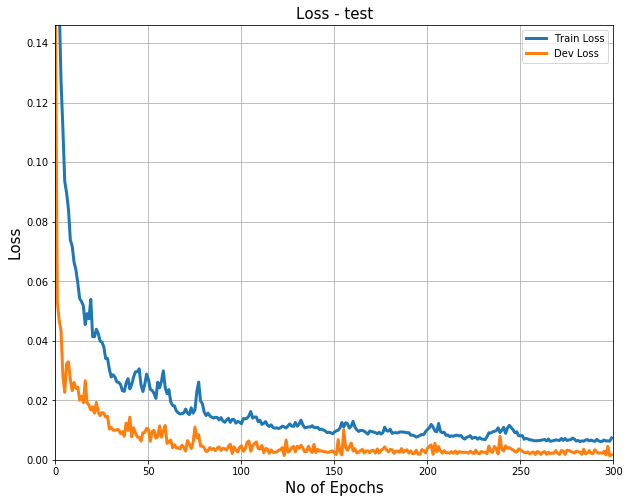

In [14]:
plot_loss(history_LSTM, title='test')

# Prediction

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


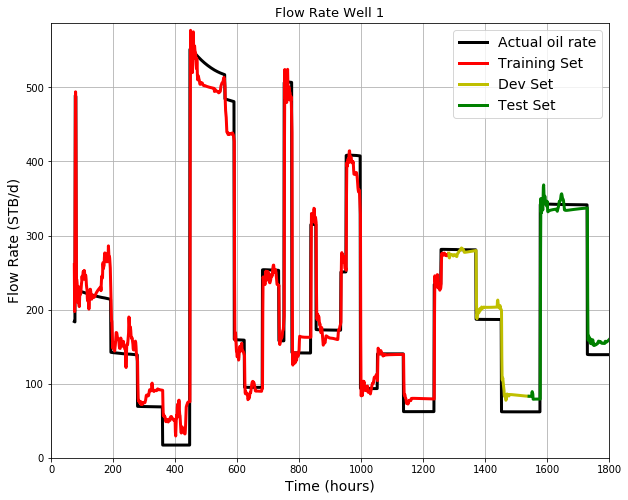

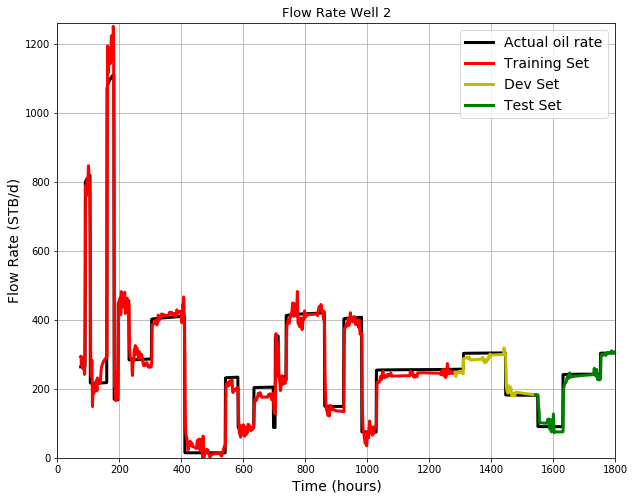

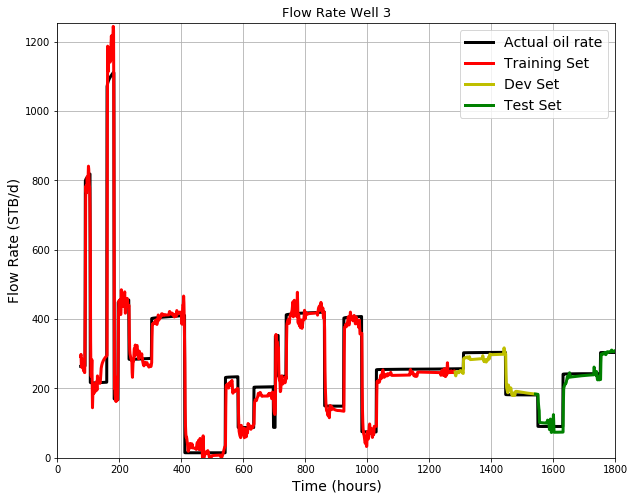

In [15]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)